# import

In [111]:
import os
import requests
from io import BytesIO
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Funções

In [112]:
def download_and_extract(start_year, end_year, temp_dir):
    years = range(start_year, end_year + 1)
    dataframe_list = []

    for year in years:
        url = f"https://www.cftc.gov/files/dea/history/deacot{year}.zip"

        try:
            # Baixar o arquivo ZIP
            response = requests.get(url)
            response.raise_for_status()  # Verificar se a solicitação foi bem-sucedida

            zip_file = zipfile.ZipFile(BytesIO(response.content))

            # Extrair o conteúdo do ZIP para um diretório temporário
            zip_file.extractall(temp_dir)

            # Listar os arquivos extraídos (certifique-se de que o arquivo desejado está presente)
            extracted_files = zip_file.namelist()
            #print("Arquivos extraído")

            # Renomear o arquivo para incluir o ano
            extracted_files = zip_file.namelist()
            for extracted_file in extracted_files:
                extracted_file_path = os.path.join(temp_dir, extracted_file)

                # Manter a mesma caixa (minúscula ou maiúscula) para a extensão
                new_file_path = os.path.join(temp_dir, f"{year}_{extracted_file.lower()}")

                # Verificar se o arquivo com o novo nome já existe
                if os.path.exists(new_file_path):
                    os.remove(new_file_path)  # Excluir o arquivo existente antes de renomear

                os.rename(extracted_file_path, new_file_path)
                print(new_file_path)

            # Não se esqueça de fechar o arquivo ZIP
            zip_file.close()

        except Exception as e:
            print(f"Erro ao processar o ano {year}: {e}")

def read_and_concat_dataframes(temp_dir, years):
    dataframe_list = []

    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            file_path = os.path.join(root, file)

            # Verificar se o arquivo é um dos que foram renomeados durante o loop de download
            if file_path.lower().endswith(".txt") and any(str(year) in file for year in years):
                df = pd.read_csv(file_path)  # Substitua '\t' pelo delimitador correto se necessário
                dataframe_list.append(df)

    cot_df = pd.concat(dataframe_list, ignore_index=True)
    return cot_df

def obter_valores_desejados():
    return [
        'CANADIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE',
        'SWISS FRANC - CHICAGO MERCANTILE EXCHANGE',
        #'MEXICAN PESO - CHICAGO MERCANTILE EXCHANGE',
        'BRITISH POUND - CHICAGO MERCANTILE EXCHANGE',
        'JAPANESE YEN - CHICAGO MERCANTILE EXCHANGE',
        'EURO FX - CHICAGO MERCANTILE EXCHANGE',
        #'BRAZILIAN REAL - CHICAGO MERCANTILE EXCHANGE',
        #'NZ DOLLAR - CHICAGO MERCANTILE EXCHANGE',
        #'SO AFRICAN RAND - CHICAGO MERCANTILE EXCHANGE',
        'AUSTRALIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE',
        #'USD INDEX - ICE FUTURES U.S.'
    ]

def filtrar_e_processar(dataframe, valor_desejado):
    # Filtrar o DataFrame
    df_filtrado = dataframe[dataframe['Market and Exchange Names'].isin(valor_desejado)]

    # Lista de colunas desejadas
    colunas_desejadas = [col for col in df_filtrado.columns if 'Noncommercial' in col or col == 'As of Date in Form YYYY-MM-DD' or col =='Market and Exchange Names']

    # Criar um novo DataFrame apenas com as colunas desejadas
    df_filtrado = df_filtrado[colunas_desejadas]
    df_filtrado['As of Date in Form YYYY-MM-DD'] = pd.to_datetime(df_filtrado['As of Date in Form YYYY-MM-DD'], errors='coerce')
    df_filtrado = df_filtrado.sort_values(by='As of Date in Form YYYY-MM-DD')
    df_filtrado = df_filtrado.drop_duplicates()

    # Adicionar colunas de posições líquidas
    df_filtrado['Noncommercial Net Positions (Other)'] = df_filtrado['Noncommercial Positions-Long (Other)'] - df_filtrado['Noncommercial Positions-Short (Other)']
    df_filtrado['Noncommercial Net Positions (Old)'] = df_filtrado['Noncommercial Positions-Long (Old)'] - df_filtrado['Noncommercial Positions-Short (Old)']
    df_filtrado['Noncommercial Net Positions (All)'] = df_filtrado['Noncommercial Positions-Long (All)'] - df_filtrado['Noncommercial Positions-Short (All)']
    
    return df_filtrado

def selecionar_moeda(valores_desejados):
    # Imprimir opções formatadas
    opcoes_formatadas = '\n'.join([f'{i+1}. {opcao}' for i, opcao in enumerate(valores_desejados)])

    # Solicitar a seleção do usuário
    currency_index = int(input(f'Selecione uma moeda:\n{opcoes_formatadas}\nEscolha o número correspondente: '))

    # Validar a entrada do usuário
    while currency_index not in range(1, len(valores_desejados) + 1):
        print('Escolha inválida. Tente novamente.')
        currency_index = int(input(f'Selecione uma moeda:\n{opcoes_formatadas}\nEscolha o número correspondente: '))

    # Obter a moeda selecionada
    selected_currency = valores_desejados[currency_index - 1]

    print(f'Você selecionou: {selected_currency}')
    return selected_currency

def cot_filtered_by_currency(dataframe,currency):
    return dataframe.loc[dataframe['Market and Exchange Names']==currency]

def categorize_columns(column_names):
    categories = {}
    
    for column_name in column_names:
        
        # Obtemos a primeira palavra do nome da coluna como categoria principal
        main_category = column_name.split()[0]
        
        # Verificamos se a coluna contém uma das palavras-chave para subcategorias
        if 'All' in column_name:
            sub_category = 'All'
        elif 'Old' in column_name:
            sub_category = 'Old'
        elif 'Other' in column_name:
            sub_category = 'Other'
        else:
            sub_category = 'Uncategorized'
        
        # Adicionamos à estrutura de categorias
        if main_category not in categories:
            categories[main_category] = {'All': [], 'Old': [], 'Other': []}
        
        categories[main_category][sub_category].append(column_name)
    
    return categories

def columns_to_categorize(dataframe):
    # Exemplo de uso
    column_names = list(dataframe.columns)
    # Remover os elementos desejados
    unwanted_elements = ['Market and Exchange Names', 'As of Date in Form YYYY-MM-DD']
    column_names = [col for col in column_names if col not in unwanted_elements]

    # Filtrar apenas colunas que contenham 'Noncommercial' no nome
    column_names = [col for col in column_names if 'Noncommercial' in col]

    return column_names

def selecionar_categoria(result):
    # Obter as categorias disponíveis
    categories = result.keys()

    # Imprimir opções formatadas
    opcoes_formatadas = '\n'.join([f'{i+1}. {categoria}' for i, categoria in enumerate(categories)])

    # Solicitar a seleção do usuário por número
    selected_category = input(f'Selecione uma categoria:\n{opcoes_formatadas}\nDigite o número correspondente: ')

    # Validar a entrada do usuário
    while not selected_category.isdigit() or int(selected_category) < 1 or int(selected_category) > len(categories):
        print('Número inválido. Tente novamente.')
        selected_category = input(f'Selecione uma categoria:\n{opcoes_formatadas}\nDigite o número correspondente: ')

    # Obter a categoria correspondente ao número
    selected_category = list(categories)[int(selected_category) - 1]

    print(f'Você selecionou: {selected_category}')
    return selected_category

def selecionar_subcategoria(result, selected_category):
    # Obter as subcategorias disponíveis para a categoria selecionada
    subcategories = result[selected_category].keys()

    # Imprimir opções formatadas
    opcoes_formatadas = '\n'.join([f'{i+1}. {subcategoria}' for i, subcategoria in enumerate(subcategories)])

    # Solicitar a seleção do usuário por número
    selected_subcategory = input(f'Selecione uma subcategoria para {selected_category}:\n{opcoes_formatadas}\nDigite o número correspondente: ')

    # Validar a entrada do usuário
    while not selected_subcategory.isdigit() or int(selected_subcategory) < 1 or int(selected_subcategory) > len(subcategories):
        print('Número inválido. Tente novamente.')
        selected_subcategory = input(f'Selecione uma subcategoria para {selected_category}:\n{opcoes_formatadas}\nDigite o número correspondente: ')

    # Obter a subcategoria correspondente ao número
    selected_subcategory = list(subcategories)[int(selected_subcategory) - 1]

    print(f'Você selecionou: {selected_subcategory}')
    return selected_subcategory

def selecionar_coluna(result, selected_category, selected_subcategory):
    # Obter as colunas disponíveis para a categoria e subcategoria selecionadas
    columns = result[selected_category][selected_subcategory]

    # Exibir opções com índices diretamente no prompt do input
    options_text = ', '.join([f'{i + 1}. {col}' for i, col in enumerate(columns)])
    selected_index = input(f'Digite o número correspondente à coluna desejada ({options_text}): ')

    # Validar se o índice é válido
    try:
        selected_index = int(selected_index)
        if 1 <= selected_index <= len(columns):
            selected_column = columns[selected_index - 1]
            print(f'Você selecionou a coluna: {selected_column}')
            return selected_column
        else:
            print('Índice inválido. Por favor, digite um número válido.')
    except ValueError:
        print('Entrada inválida. Por favor, digite um número.')

def positions_change_format(dataframe,result):
    dataframe[result['Change']['All']] = dataframe[result['Change']['All']].astype('int64')
    return dataframe

def criar_boxplot(dataframe, coluna_selecionada):
    # Selecione as colunas para as quais você deseja criar box plots
    colunas_para_boxplot = [coluna_selecionada]

    # Crie box plots para cada coluna selecionada
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")  # Configuração do estilo da grade

    for coluna in colunas_para_boxplot:
        sns.boxplot(x=dataframe[coluna])
        plt.title(f'Box Plot para {coluna}')
        plt.show()

def criar_serie_temporal(dataframe, coluna_temporal):
    # Configuração do estilo
    sns.set(style="whitegrid")

    # Crie um gráfico de linha (série temporal)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=dataframe['As of Date in Form YYYY-MM-DD'], y=dataframe[coluna_temporal])
    plt.title(f'Série Temporal para {coluna_temporal}')
    plt.xlabel('Data')
    plt.ylabel(coluna_temporal)

    # Adicione linhas horizontais para os quartis da coluna selecionada
    quartis = dataframe[coluna_temporal].quantile([0.25, 0.5, 0.75])
    for quartil, cor in zip(quartis, ['r', 'g', 'b']):
        plt.axhline(y=quartil, color=cor, linestyle='--', label=f'Quartil {quartil:.2f}')

    plt.legend()  # Adicione a legenda para indicar os quartis
    plt.show()

def escolher_par_moedas(pares_moedas):
    """
    Função para apresentar os pares de moedas ao usuário e permitir que escolha um par.

    Parameters:
    - pares_moedas (list): Lista dos pares de moedas.

    Returns:
    - str: Par de moedas escolhido pelo usuário.
    """

    # Criar o texto do prompt com os pares de moedas e seus índices
    prompt_text = "\n".join([f"{i + 1}. {par}" for i, par in enumerate(pares_moedas)])
    prompt_text += "\nEscolha o índice do par de moedas desejado: "

    # Solicitar ao usuário que escolha um índice
    indice_escolhido = int(input(prompt_text)) - 1

    # Garantir que o índice escolhido esteja dentro dos limites
    if 0 <= indice_escolhido < len(pares_moedas):
        return pares_moedas[indice_escolhido]
    else:
        print("Índice inválido. Encerrando o programa.")
        return None

def obter_pares():
    """
    Função para obter a lista dos principais pares de moedas no Yahoo Finance.

    Returns:
    - list: Lista dos pares de moedas.
    """
    return [
        'CADUSD=X',
        'CHFUSD=X',
        'JPYUSD=X',
        'GBPUSD=X',
        'EURUSD=X',
        'AUDUSD=X',
    ]

def obter_dados_forex(year, selected_pair):
    """
    Função para obter dados históricos de Forex para um par específico.

    Args:
    - year (int): Ano inicial para os dados.
    - selected_pair (str): Par de moedas selecionado.

    Returns:
    - pd.DataFrame: DataFrame contendo os dados históricos.
    """
    # Especifique os símbolos dos pares de moedas e o intervalo desejado
    symbols = [selected_pair]
    start_date = f'{str(year)}-01-01'
    end_date = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')

    # Crie um DataFrame vazio para armazenar os dados
    df = pd.DataFrame()

    # Itere sobre os símbolos e obtenha os dados para cada par de moedas
    for symbol in symbols:
        data = yf.download(symbol, start=start_date, end=end_date)
        data['Symbol'] = symbol  # Adicione uma coluna com o símbolo do par de moedas
        df = pd.concat([df, data])

    # Renomeie as colunas para torná-las mais amigáveis, se necessário
    df = df.rename(columns={'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Volume': 'Volume'})

    # Reset o índice para trazer a data de volta como uma coluna
    df = df.reset_index()

    return df

def merge_cot_with_forex(cot_df, price_df, days_delay=3):
    """
    Função para mesclar relatório COT com dados de preços Forex considerando o atraso.

    Args:
    - cot_df (pd.DataFrame): DataFrame contendo o relatório COT.
    - price_df (pd.DataFrame): DataFrame contendo os dados de preços Forex.
    - days_delay (int): Número de dias de atraso na publicação do relatório COT (padrão é 3 dias).

    Returns:
    - pd.DataFrame: DataFrame resultante da mesclagem.
    """
    # Adicionar uma coluna com as datas deslocadas para considerar o atraso
    cot_df['Delayed Date'] = cot_df['As of Date in Form YYYY-MM-DD'] + pd.DateOffset(days=days_delay)

    # Filtrar as datas no price_df que estão presentes no cot_df
    filtered_price_df = price_df[price_df['Date'].isin(cot_df['Delayed Date'])]

    # Merge dos DataFrames usando a coluna de datas deslocadas
    merged_df = pd.merge(cot_df, filtered_price_df, how='inner', left_on='Delayed Date', right_on='Date')

    return merged_df

def insert_signals_on_df(merged_df,df,sinal_compra,sinal_venda):
    # Aplicar o filtro
    # Adicionar uma coluna indicando se ocorreu um sinal fora dos quartis
    merged_df['Sinal_Compra'] = sinal_compra.astype(int)
    merged_df['Sinal_Venda'] = sinal_venda.astype(int)
    # Deslocar a coluna para representar os preços futuros
    merged_df['Sinal_Compra'] = merged_df['Sinal_Compra'].shift(+1)
    merged_df['Sinal_Venda'] = merged_df['Sinal_Venda'].shift(+1)

    # Calcular a diferença percentual nos preços após o sinal
    #merged_df['Delta_Price_After_Signal'] = merged_df['Close'].pct_change()
    df_save = df 
    df = df_save
    # Certifique-se de que a coluna de datas está no formato datetime em ambos os dataframes
    df['Date'] = pd.to_datetime(df['Date'])
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])

    # Renomeie a coluna 'Date' em df para evitar conflitos após o merge

    df = df.rename(columns={'Date': 'Original Date'})

    # Realize o merge usando a coluna de datas
    df = pd.merge(df, merged_df[['Date', 'Sinal_Compra', 'Sinal_Venda']], left_on='Original Date', right_on='Date', how='left')

    # Drop das colunas desnecessárias após o merge
    df = df.drop(columns=['Date'])

    # Agora df contém as colunas 'Sinal_Compra' e 'Sinal_Venda'
    df[['Sinal_Compra', 'Sinal_Venda']] = df[['Sinal_Compra', 'Sinal_Venda']].fillna(0.0)

    return df

def get_signal_dates(df):
    data_de_sinal = list(df[(df['Sinal_Venda'] == 1) | (df['Sinal_Compra'] == 1)]['Original Date'].unique())
    return data_de_sinal

def calcular_resultados_teste(df, take_profit, take_loss,selected_pair,sinal='Sinal 1'):
    """
    Calcula os resultados de um teste com base nos sinais de compra e venda.

    Parâmetros:
    - df: DataFrame
        O DataFrame contendo os dados do preço forex.
    - take_profit: int
        O valor do take profit em pips.
    - take_loss: int
        O valor do take loss em pips.
    - sinal_compra: pandas Series
        Uma série booleana indicando os períodos de sinal de compra.
    - sinal_venda: pandas Series
        Uma série booleana indicando os períodos de sinal de venda.

    Retorna:
    - testes_df: DataFrame
        Um DataFrame contendo os resultados do teste.
    """
    testes_data = []

    # Obtém as datas de sinal
    data_de_sinal = get_signal_dates(df)

    # Cria listas para armazenar vitórias e derrotas com as respectivas datas
    vitorias = []
    derrotas = []

    # Itera sobre as datas de sinal
    for data_sinal in data_de_sinal:
        # Filtra o DataFrame para incluir apenas os dados dentro da janela de 15 dias
        df_janela = df[(df['Original Date'] >= data_sinal) & (df['Original Date'] <= data_sinal + pd.Timedelta(days=60))]

        # Determina se o sinal foi de compra ou venda
        sinal_type = 'Compra' if df.loc[df['Original Date'] == data_sinal, 'Sinal_Compra'].values[0] == 1 else 'Venda'

        # Calcula o valor em pips
        if selected_pair == 'JPYUSD=X':
            pip_value = 1 / 1000000
        else:
            pip_value = 1 / 10000
        close_price = df_janela.loc[df_janela['Original Date'] == data_sinal, 'Close'].values[0]

        # Calcula os níveis de take profit e take loss
        tp_level = close_price + take_profit * pip_value if sinal_type == 'Compra' else close_price - take_profit * pip_value
        tl_level = close_price - take_loss * pip_value if sinal_type == 'Compra' else close_price + take_loss * pip_value

        # Inicializa variáveis para contabilizar resultados
        vitoria = False
        derrota = False
        data_resultado = None

        # Itera sobre os valores para verificar os resultados
        for index, row in df_janela.iterrows():
            high_value = row['High']
            low_value = row['Low']

            if sinal_type == 'Compra':
                if high_value > tp_level:
                    vitoria = True
                    data_resultado = row['Original Date']
                    break
                elif low_value < tl_level:
                    derrota = True
                    data_resultado = row['Original Date']
                    break
            elif sinal_type == 'Venda':
                if low_value < tp_level:
                    vitoria = True
                    data_resultado = row['Original Date']
                    break
                elif high_value > tl_level:
                    derrota = True
                    data_resultado = row['Original Date']
                    break

        # Armazena o resultado
        if vitoria:
            vitorias.append({'Data_Sinal': data_sinal, 'Data_Resultado': data_resultado})
        elif derrota:
            derrotas.append({'Data_Sinal': data_sinal, 'Data_Resultado': data_resultado})

    # Calcula a média e o máximo dos intervalos de dias para vitórias
    media_intervalo_vitorias = sum([(vitoria['Data_Resultado'] - vitoria['Data_Sinal']).days for vitoria in vitorias]) / len(vitorias) if len(vitorias) > 0 else 0
    max_intervalo_vitorias = max([(vitoria['Data_Resultado'] - vitoria['Data_Sinal']).days for vitoria in vitorias], default=0)

    # Calcula a média e o máximo dos intervalos de dias para derrotas
    media_intervalo_derrotas = sum([(derrota['Data_Resultado'] - derrota['Data_Sinal']).days for derrota in derrotas]) / len(derrotas) if len(derrotas) > 0 else 0
    max_intervalo_derrotas = max([(derrota['Data_Resultado'] - derrota['Data_Sinal']).days for derrota in derrotas], default=0)

    try:
        aprov = round(len(vitorias) / (len(vitorias) + len(derrotas)), 2)
    except:
        aprov = 0

    testes_info = {'Teste': f'{selected_pair}','Sinal':sinal, 'TP': take_profit, 'TL': take_loss, 'Média Dias Vitória': media_intervalo_vitorias, 'Max Dias Vitoria': max_intervalo_vitorias, 'Média Dias Derrota': media_intervalo_derrotas, 'Max Dias Derrota': max_intervalo_derrotas, 'Aproveitamento': aprov, 'Trades': len(vitorias) + len(derrotas)}
    testes_data.append(testes_info)
    testes_df = pd.DataFrame(testes_data)
    testes_df['retorno/invest'] = testes_df['Trades'] * ((testes_df['TP'] / testes_df['TL']) * testes_df['Aproveitamento'] - (1 - testes_df['Aproveitamento']))

    return testes_df

def plot_trade_evolution(df,selected_pair,take_profit,take_loss, last_trades = 0):
    data_de_sinal = get_signal_dates(df)
    data_de_sinal = data_de_sinal[-last_trades:]
    for data_sinal in data_de_sinal:
        # Filtrar o DataFrame para incluir apenas os dados dentro da janela de 15 dias
        df_janela = df[(df['Original Date'] >= data_sinal) & (df['Original Date'] <= data_sinal + pd.Timedelta(days=60))]

        # Determinar se o sinal foi de compra ou venda
        sinal_type = 'Compra' if df.loc[df['Original Date'] == data_sinal, 'Sinal_Compra'].values[0] == 1 else 'Venda'

        # Criar o gráfico
        plt.figure(figsize=(10, 6))
        plt.plot(df_janela['Original Date'], df_janela['High'], label='High', color='green')
        plt.plot(df_janela['Original Date'], df_janela['Low'], label='Low', color='red')
        plt.axhline(y=df_janela.loc[df_janela['Original Date'] == data_sinal, 'Close'].values[0], color='blue', linestyle='--', label=f'Close on Signal Day ({sinal_type})')

        # Calcular o valor em pips
        if selected_pair =='JPYUSD=X':
            pip_value = 1/1000000
        else:
            pip_value = 1 / 10000

        close_price = df_janela.loc[df_janela['Original Date'] == data_sinal, 'Close'].values[0]
        if sinal_type == 'Compra':
            plt.axhline(y=close_price + take_profit * pip_value, color='orange', linestyle='--', label=f'Close + {take_profit} pips')
            plt.axhline(y=close_price - take_loss * pip_value, color='purple', linestyle='--', label=f'Close - {take_loss} pips')
        else:  # Sinal de Venda
            plt.axhline(y=close_price - take_profit * pip_value, color='orange', linestyle='--', label=f'Close - {take_profit} pips')
            plt.axhline(y=close_price + take_loss * pip_value, color='purple', linestyle='--', label=f'Close + {take_loss} pips')

        # Adicionar rótulos e título
        plt.xlabel('Data')
        plt.ylabel('Preço')
        plt.title(f'Variação de Preços após Sinal em {data_sinal} ({sinal_type})')
        plt.legend()
        plt.show()

def plot_signal_chart(df,selected_pair,days=30):
    # Obtendo a data atual
    data_fim = datetime.now().strftime('%Y-%m-%d')

    # Obtendo a data de início 30 dias atrás
    data_inicio = (datetime.now() - timedelta(days)).strftime('%Y-%m-%d')


    print(f'Data inicial: {data_inicio}')
    print(f'Data final: {data_fim}')


    # Converter as strings de data em objetos datetime
    data_inicio = pd.to_datetime(data_inicio)
    data_fim = pd.to_datetime(data_fim)

    # Filtre o DataFrame para incluir apenas as datas dentro da janela temporal
    df_janela_temporal = df[(df['Original Date'] >= data_inicio) & (df['Original Date'] <= data_fim)]

    # Crie um gráfico de linha para os preços de fechamento
    plt.figure(figsize=(12,6))
    plt.plot(df_janela_temporal['Original Date'], df_janela_temporal['Close'], label='Preço de Fechamento', color='blue', linewidth=2)

    # Adicione marcadores para os pontos de compra (verde) e venda (vermelho)
    plt.scatter(df_janela_temporal[df_janela_temporal['Sinal_Compra'] == 1]['Original Date'], df_janela_temporal[df_janela_temporal['Sinal_Compra'] == 1]['Close'], label='Compra', color='green', marker='^', s=100)
    plt.scatter(df_janela_temporal[df_janela_temporal['Sinal_Venda'] == 1]['Original Date'], df_janela_temporal[df_janela_temporal['Sinal_Venda'] == 1]['Close'], label='Venda', color='red', marker='v', s=100)

    # Adicione rótulos e título ao gráfico
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.title(f'Preços de Fechamento do {selected_pair} com Sinais de Compra e Venda')
    plt.legend()

    # Ajuste os limites do eixo x para a janela temporal desejada
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    # Adicione linhas de grade (grid)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Exiba o gráfico
    plt.show()

def profit_ratio_signal_test(selected_pair,merged_df,df,sinais_compra,sinais_venda,TL=50,beta=''):
    lista = []
    for N in range(1,len(sinais_compra)+1):
        sinal_compra =sinais_compra[N-1]
        sinal_venda = sinais_venda[N-1]
        df_ = insert_signals_on_df(merged_df,df,sinal_compra,sinal_venda)
    # Defina os parâmetros de take profit e take loss
        for i in range(TL,200+25,25):

            take_loss = i  # pips
            for ratio in [2,2.5,3]:
                
                take_profit = ratio*take_loss  # pips
                # Exemplo de uso
                testes_df = calcular_resultados_teste(df_, take_profit, take_loss,selected_pair,f'Sinal {N}')
                lista.append(testes_df)
    testes_df = pd.concat(lista,ignore_index=True)
    testes_df = testes_df.sort_values(by='retorno/invest',ascending=False)

    testes_df.to_csv(f'COT_data/{selected_pair+beta}.csv')

    return testes_df

def read_test_data(pares_moedas,directory='COT_data/',v=''):
    df_lista = []
    for par in pares_moedas:
        df = pd.read_csv(directory+f'{par+v}.csv')
        df_lista.append(df)

    testes_combinados = pd.concat(df_lista,ignore_index=True)
    return testes_combinados.sort_values(by='retorno/invest',ascending=False)

# Dataframe COT para moeda

In [113]:
# Sinais de compra e venda
a = 0.2
b = 0.8
beta='2'
valores_desejados = obter_valores_desejados()
pares_moedas = obter_pares()
temp_directory = "COT_data"
year = 2022 #int(input('Digite o ano inicial:'))
download_and_extract(year, 2024, temp_directory)

COT_data\2022_annual.txt
COT_data\2023_annual.txt
COT_data\2024_annual.txt


In [114]:
for i in range(0,len(pares_moedas)):
    cot_df = read_and_concat_dataframes(temp_directory, range(year, 2025))
    cot_df = filtrar_e_processar(cot_df,valores_desejados)
    column_names = columns_to_categorize(cot_df)
    result = categorize_columns(column_names)
    cot_df = positions_change_format(cot_df,result)
    selected_currency = valores_desejados[i]
    cot_df = cot_filtered_by_currency(cot_df, selected_currency)
    selected_pair = pares_moedas[i]
    df = obter_dados_forex(2022, selected_pair)
    merged_df = merge_cot_with_forex(cot_df, df)

    # Calcular os quartis para 'Change in Noncommercial-Long (All)'
    lower_quartile_long = merged_df['Change in Noncommercial-Long (All)'].quantile(a)
    upper_quartile_long = merged_df['Change in Noncommercial-Long (All)'].quantile(b)
    # Calcular os quartis para 'Change in Noncommercial-Long (All)'
    lower_quartile_short = merged_df['Change in Noncommercial-Short (All)'].quantile(a)
    upper_quartile_short = merged_df['Change in Noncommercial-Short (All)'].quantile(b)
    upper_quartile_net = merged_df['Noncommercial Net Positions (All)'].quantile(b)
    lower_quartile_net = merged_df['Noncommercial Net Positions (All)'].quantile(a)
    median_quartial_net = merged_df['Noncommercial Net Positions (All)'].median()
    # Calcular a mediana para 'Noncommercial Net Positions (All)'
    median_net = merged_df['Noncommercial Net Positions (All)'].median()
    # # Criar um filtro para selecionar apenas as linhas nos quartis superiores e inferiores
    sinal_compra1 = (merged_df['Change in Noncommercial-Long (All)'] > upper_quartile_long)#&(merged_df['Change in Noncommercial-Short (All)'] < lower_quartile_short)
    sinal_venda1 = (merged_df['Change in Noncommercial-Short (All)'] > upper_quartile_short)#&(merged_df['Change in Noncommercial-Long (All)'] < lower_quartile_long)
    sinal_compra3 = (merged_df['Noncommercial Net Positions (All)'] < upper_quartile_net)&(merged_df['Noncommercial Net Positions (All)'] > median_quartial_net)
    sinal_venda3 = (merged_df['Noncommercial Net Positions (All)'] > lower_quartile_net)&(merged_df['Noncommercial Net Positions (All)'] < median_quartial_net)
    sinal_venda2 = merged_df['Noncommercial Net Positions (All)'] > upper_quartile_net
    sinal_compra2 = merged_df['Noncommercial Net Positions (All)'] < lower_quartile_net
    # Criar sinais de compra e venda com base no cruzamento da Net Positions com a mediana
    sinal_compra4 = (merged_df['Noncommercial Net Positions (All)'].shift(-1) > median_net) & (merged_df['Noncommercial Net Positions (All)'] < median_net)
    sinal_venda4 = (merged_df['Noncommercial Net Positions (All)'].shift(-1) < median_net) & (merged_df['Noncommercial Net Positions (All)'] > median_net)
    # Criar sinal de compra quando Changes Long cruzar para cima e sinal de venda quando cruzar para baixo
    sinal_compra5 = (merged_df['Change in Noncommercial-Long (All)'].shift(-1) > 0) & (merged_df['Change in Noncommercial-Long (All)'] < 0)
    sinal_venda5 = (merged_df['Change in Noncommercial-Long (All)'].shift(-1) < 0) & (merged_df['Change in Noncommercial-Long (All)'] > 0)
    # Criar sinal de compra quando Changes Short cruzar para baixo e sinal de venda quando cruzar para cima
    sinal_compra6 = (merged_df['Change in Noncommercial-Short (All)'].shift(-1) < 0) & (merged_df['Change in Noncommercial-Short (All)'] > 0)
    sinal_venda6 = (merged_df['Change in Noncommercial-Short (All)'].shift(-1) > 0) & (merged_df['Change in Noncommercial-Short (All)'] < 0)
    # Criar sinal de compra quando Net Positions cruzar para cima e sinal de venda quando cruzar para baixo
    sinal_compra7 = (merged_df['Noncommercial Net Positions (All)'].shift(-1) > 0) & (merged_df['Noncommercial Net Positions (All)'] < 0)
    sinal_venda7 = (merged_df['Noncommercial Net Positions (All)'].shift(-1) < 0) & (merged_df['Noncommercial Net Positions (All)'] > 0)
    sinais_compra = [sinal_compra1,sinal_compra2,sinal_compra3,sinal_compra4,sinal_compra5,sinal_compra6,sinal_compra7]
    sinais_venda = [sinal_venda1,sinal_venda2,sinal_venda3,sinal_venda4,sinal_venda5,sinal_venda6,sinal_venda7]
    # Teste do sinal

    testes_df = profit_ratio_signal_test(selected_pair,merged_df,df,sinais_compra,sinais_venda,beta=beta)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [115]:
resultados2 =read_test_data(pares_moedas,v='2').drop(columns=['Unnamed: 0'])

# Sinais por moeda

In [116]:
#EUR,AUD,CHF
resultados2[(resultados2['Teste'] == 'AUDUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 2,AUDUSD=X,250.0,100,24.300000,53,7.000000,18,0.50,40,30.00
Sinal 4,AUDUSD=X,150.0,50,7.625000,12,2.888889,11,0.47,17,14.96
Sinal 1,AUDUSD=X,100.0,50,6.533333,17,2.333333,5,0.45,33,11.55
Sinal 5,AUDUSD=X,150.0,75,7.619048,32,5.281250,13,0.40,53,10.60
Sinal 3,AUDUSD=X,150.0,50,9.736842,32,3.500000,41,0.29,65,10.40


In [117]:
resultados2[(resultados2['Teste'] == 'EURUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 6,EURUSD=X,375.0,125,30.250000,55,13.966667,53,0.35,46,18.40
Sinal 3,EURUSD=X,375.0,125,28.368421,55,12.300000,48,0.32,59,16.52
Sinal 5,EURUSD=X,375.0,125,33.062500,59,14.918919,60,0.30,53,10.60


In [118]:
resultados2[(resultados2['Teste'] == 'CHFUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 5,CHFUSD=X,187.5,75,11.296296,39,5.162162,28,0.42,64,30.08
Sinal 2,CHFUSD=X,300.0,100,20.611111,40,10.222222,60,0.40,45,27.00
Sinal 3,CHFUSD=X,225.0,75,15.800000,39,4.395349,13,0.32,63,17.64
Sinal 1,CHFUSD=X,125.0,50,4.384615,12,2.761905,6,0.38,34,11.22


In [119]:
resultados2[(resultados2['Teste'] == 'CADUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 2,CADUSD=X,100.0,50,8.833333,28,5.681818,20,0.52,46,25.760
Sinal 6,CADUSD=X,125.0,50,10.411765,27,7.750000,33,0.35,49,11.025


In [120]:
resultados2[(resultados2['Teste'] == 'GBPUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 5,GBPUSD=X,150.0,50,6.388889,20,2.617647,11,0.35,52,20.80
Sinal 2,GBPUSD=X,375.0,125,19.071429,48,8.200000,21,0.36,39,17.16
Sinal 6,GBPUSD=X,187.5,75,6.937500,24,2.833333,13,0.40,40,16.00
Sinal 4,GBPUSD=X,125.0,50,4.000000,6,0.000000,0,0.78,9,15.57
Sinal 3,GBPUSD=X,375.0,125,22.736842,48,9.418605,45,0.31,62,14.88


In [121]:
resultados2[(resultados2['Teste'] == 'JPYUSD=X')&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 5,JPYUSD=X,225.0,75,15.850000,55,5.297297,25,0.35,57,22.800
Sinal 6,JPYUSD=X,200.0,100,18.952381,55,8.148148,32,0.44,48,15.360
Sinal 2,JPYUSD=X,187.5,75,24.600000,59,8.080000,53,0.38,40,13.200
Sinal 4,JPYUSD=X,187.5,75,11.333333,24,7.600000,24,0.55,11,10.175


# Section

In [190]:
cot_df = read_and_concat_dataframes(temp_directory, range(year, 2025))
cot_df = filtrar_e_processar(cot_df,valores_desejados)
column_names = columns_to_categorize(cot_df)
result = categorize_columns(column_names)
cot_df = positions_change_format(cot_df,result)
selected_currency = selecionar_moeda(valores_desejados)
cot_df = cot_filtered_by_currency(cot_df, selected_currency)
selected_pair = escolher_par_moedas(pares_moedas)
df = obter_dados_forex(2022, selected_pair)
merged_df = merge_cot_with_forex(cot_df, df)

Você selecionou: AUSTRALIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE


[*********************100%%**********************]  1 of 1 completed


In [191]:
resultados2[(resultados2['Teste'] == selected_pair)&(resultados2['retorno/invest']>10)].groupby('Sinal').first().sort_values('retorno/invest',ascending=False)

,Teste,TP,TL,Média Dias Vitória,Max Dias Vitoria,Média Dias Derrota,Max Dias Derrota,Aproveitamento,Trades,retorno/invest
Sinal,,,,,,,,,,
Sinal 2,AUDUSD=X,250.0,100,24.300000,53,7.000000,18,0.50,40,30.00
Sinal 4,AUDUSD=X,150.0,50,7.625000,12,2.888889,11,0.47,17,14.96
Sinal 1,AUDUSD=X,100.0,50,6.533333,17,2.333333,5,0.45,33,11.55
Sinal 5,AUDUSD=X,150.0,75,7.619048,32,5.281250,13,0.40,53,10.60
Sinal 3,AUDUSD=X,150.0,50,9.736842,32,3.500000,41,0.29,65,10.40


In [204]:
N = int(input('N:'))
sinal_compra =sinais_compra[N-1]
sinal_venda = sinais_venda[N-1]

In [205]:
df_ = insert_signals_on_df(merged_df,df,sinal_compra,sinal_venda)

Data inicial: 2024-02-10
Data final: 2024-02-25


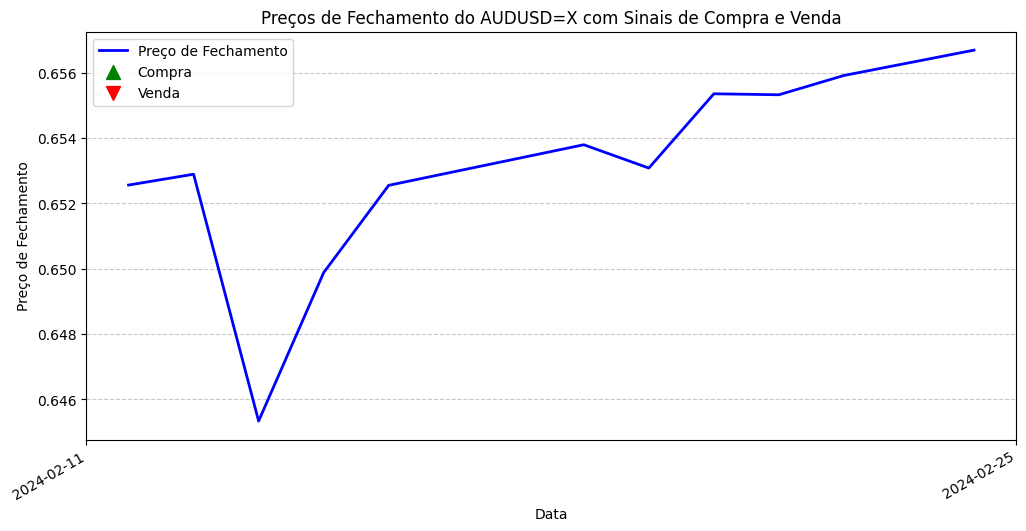

In [206]:
plot_signal_chart(df_,selected_pair,days=15)